In [1]:
import comet_ml
# Replace with your actual Comet API key
comet_api_key = "yd6X45GKLWoIKspb4dChTuwOs"
import torch 
import torch.optim as optim
import torch.nn as nn

import mitdeeplearning as mdl
import numpy as np
import time , os , functools
from IPython import display
from tqdm import tqdm
from scipy.io.wavfile import write

# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


In [2]:
songs = mdl.lab1.load_training_data()

exa = songs[3]
print(exa)

Found 817 songs in text
X:4
T:Blackbird
Z: id:dc-hornpipe-4
M:C|
L:1/8
K:D Mixolydian
AG|F2FA GFD2|de (3fed d^cAF|G2GF GFDE|FdcA G2AG|!
F2FA GFD2|de (3fed d^cAG|AdcA GcAG|F2D2 D2:|!
fg|agfa gfeg|fd e^c d=cA2|agfa gfde|fdgf e2 fg|!
a2ge f3e|d^cde fdAG|AdcA GcAG|F2D2 D2:|!


In [3]:
mdl.lab1.play_song(exa)

In [4]:
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [5]:
char2idx = {u: i for i, u in enumerate(vocab)}

idx2char = np.array(vocab)

In [6]:
print('{')
for char, _ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [7]:
### Vectorize the songs string ###

'''TODO: Write a function to convert the all songs string to a vectorized
    (i.e., numeric) representation. Use the appropriate mapping
    above to convert from vocab characters to the corresponding indices.

  NOTE: the output of the `vectorize_string` function
  should be a np.array with `N` elements, where `N` is
  the number of characters in the input string
'''
songs_joined = "\n\n".join(songs)
def vectorize_string(string):
  vectorize_string = np.array([char2idx[char] for char in string])
  return vectorize_string

vectorized_songs = vectorize_string(songs_joined)

In [8]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [9]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
    # the length of the vectorized songs string
    n = vectorized_songs.shape[0] - 1
    # randomly choose the starting indices for the examples in the training batch
    idx = np.random.choice(n - seq_length, batch_size)

    '''TODO: construct a list of input sequences for the training batch'''
    input_batch = [vectorized_songs[i : i +seq_length] for i in idx]

    '''TODO: construct a list of output sequences for the training batch'''
    output_batch = [vectorized_songs[i+1 : i + seq_length +1] for i in idx]

    # Convert the input and output batches to tensors
    x_batch = torch.tensor(input_batch, dtype=torch.long)
    y_batch = torch.tensor(output_batch, dtype=torch.long)

    return x_batch, y_batch

# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
x_batch, y_batch = get_batch(*test_args)
assert x_batch.shape == (2, 10), "x_batch shape is incorrect"
assert y_batch.shape == (2, 10), "y_batch shape is incorrect"
print("Batch function works correctly!")


C:\Users\omkum\AppData\Local\Temp\ipykernel_22024\1905349825.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  x_batch = torch.tensor(input_batch, dtype=torch.long)


Batch function works correctly!


In [10]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(x_batch[0], y_batch[0])):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx.item()])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx.item()])))

Step   0
  input: 2 (np.str_('!'))
  expected output: 0 (np.str_('\n'))
Step   1
  input: 0 (np.str_('\n'))
  expected output: 62 (np.str_('g'))
Step   2
  input: 62 (np.str_('g'))
  expected output: 82 (np.str_('|'))
Step   3
  input: 82 (np.str_('|'))
  expected output: 61 (np.str_('f'))
Step   4
  input: 61 (np.str_('f'))
  expected output: 14 (np.str_('2'))


Defining the RNN Model

In [11]:
# defining the model 
class lstmmodel(nn.Module):
    def __init__(self,vocab_size,embedding_dim , hidden_size):
        super(lstmmodel ,self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size , embedding_dim)

        self.lstm = nn.LSTM(embedding_dim , hidden_size , batch_first = True)

        self.fc = nn.Linear(hidden_size , vocab_size)

    def init_hidden (self,batch_size,device) :
        #initialize both hidden state and cell state
        return (torch.zeros(1,batch_size,self.hidden_size).to(device),
                torch.zeros(1,batch_size,self.hidden_size).to(device))
    def forward(self, x , state = None , return_state = False ):
        x = self.embedding(x)

        if state is None :
            state = self.init_hidden(x.size(0) , x.device)
        out,state = self.lstm(x , state)

        out = self.fc(out)
        return out if not return_state else (out,state)

In [12]:
vocab_size = len(vocab)
embedding_dim = 256 
hidden_size = 1024
batch_size = 8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = lstmmodel(vocab_size,embedding_dim,hidden_size).to(device)

print(model)

Using device: cpu
lstmmodel(
  (embedding): Embedding(83, 256)
  (lstm): LSTM(256, 1024, batch_first=True)
  (fc): Linear(in_features=1024, out_features=83, bias=True)
)


#### Testing the data

In [13]:
x , y = get_batch(vectorized_songs , seq_length=100 , batch_size=32)
x = x.to(device)
y = y.to(device)

pred = model(x)
print(f"Input shape :  {x.shape} ")
print(f"prediction shape :   {pred.shape}")

Input shape :  torch.Size([32, 100]) 
prediction shape :   torch.Size([32, 100, 83])


In [14]:
sampled_indices = torch.multinomial(torch.softmax(pred[0], dim=-1), num_samples=1)
sampled_indices = sampled_indices.squeeze(-1).cpu().numpy()
sampled_indices

array([34, 49, 31, 11, 72, 14,  0, 76, 64, 62, 67,  8, 26, 67, 23, 67, 82,
       81, 47, 55, 74, 41, 51, 19, 74, 47, 61,  2, 25, 35, 53, 58, 46, 68,
       27, 57, 56, 45, 67, 82, 71, 29, 33, 64, 42, 66, 41, 21, 74,  2, 31,
       29, 54, 27,  4, 57, 45, 51,  1, 53, 13, 17, 60, 57, 56,  8, 26, 67,
       73, 48,  1, 51,  5, 27, 25, 69, 46,  1, 79, 62, 29,  4, 62, 48, 59,
       57, 56,  9, 68, 40, 55, 46, 11, 61, 34, 10, 65, 11, 56, 73])

In [15]:
print("Input: \n", repr("".join(idx2char[x[0].cpu()])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'l-152\nM:C\nL:1/8\nK:D Major\nz|D2FA d2ed|cdBd AFF2|BAGB ADFA|BAGF EGFE|!\nD2FA d2ed|cdBd AFF2|BAGB ABde|'

Next Char Predictions: 
 "IXF/q2\nuigl,Al<l|zV_sPZ7sVf!>J]cUmBbaTl|pDHiQkP9s!FD^B#bTZ ]15eba,AlrW Z'B>nU xgD#gWdba-mO_U/fI.j/ar"


#### Training the model and Loss checking operation

#### Defining the Lossy Function

In [16]:
### Defining The Lossy Function ###
Cross_entropy = nn.CrossEntropyLoss()
def compute_loss(labels , logits ):
    """
        Inputs :
            labels: (batch_size , sequence_length)
            logits: (batch_size , sequence_length , vocab_size)

        output : 
            loss : scalar cross entropy loss over the batch and sequence length
        """

    batched_labels = labels.view(-1)
    batched_logits = logits.view(-1 , logits.size(-1))

    loss = Cross_entropy(batched_logits , batched_labels)
    return loss 

In [17]:
### Compute the loss on the prediction from the untrained model from earlier ###
y.shape 
pred.shape

example_batch_loss = compute_loss( y, pred)

print(f"Prediction Shape: {pred.shape} #(Batch_size , Sequence_lenght , vocab_size)")
print(f"Scalar.loss : {example_batch_loss.mean().item()}")

Prediction Shape: torch.Size([32, 100, 83]) #(Batch_size , Sequence_lenght , vocab_size)
Scalar.loss : 4.423388957977295


In [36]:
### HyperParameters Setting and Optimization ###
Vocal_size = len(vocab)

# Model Parameters
para = dict(
    num_training_iterations = 300, 
     batch_size = 8,
     seq_length = 100,
     learning_rate = 5e-3,
     embedding_dim = 256,
     hidden_size = 1024
)

#CHeckout Points 
Checkpoint_dir = './Training_checkpoints'
checkpoint_prefix = os.path.join(Checkpoint_dir , "my_ckpt")
os.makedirs(Checkpoint_dir , exist_ok=True )

In [31]:
### CREATE a Comet Experiment to track Our training Experiment ###

def create_experiment ():
    # End any Prior Experiments 
    if 'experiment' in locals():
        experiment.end()

    experiment = comet_ml.Experiment(
        api_key=comet_api_key ,
        project_name = "Genrating_Music" )

    # log our hyperparameters  , defined above , to the parameters
    for param , value  in para.items():
        experiment.log_parameter(param , value)
    experiment.flush()

    return experiment

In [23]:
### Define optimizer and training operation ###
model = lstmmodel(vocab_size , embedding_dim , hidden_size)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

def train_step(x,y):
    model.train()

    optimizer.zero_grad()

    y_hat = model(x)

    loss = compute_loss(y , y_hat)
    loss.backward()
    optimizer.step()

    return loss

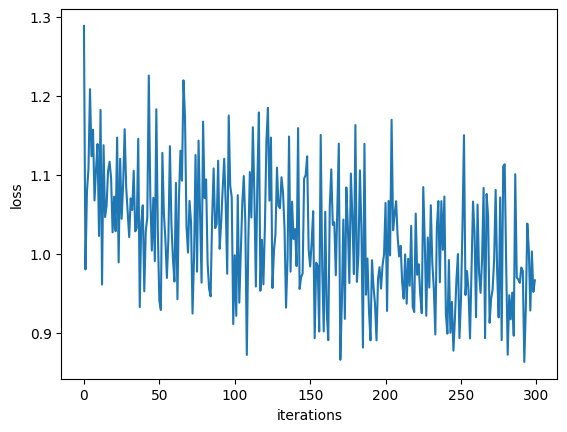

100%|██████████| 300/300 [08:24<00:00,  1.68s/it]


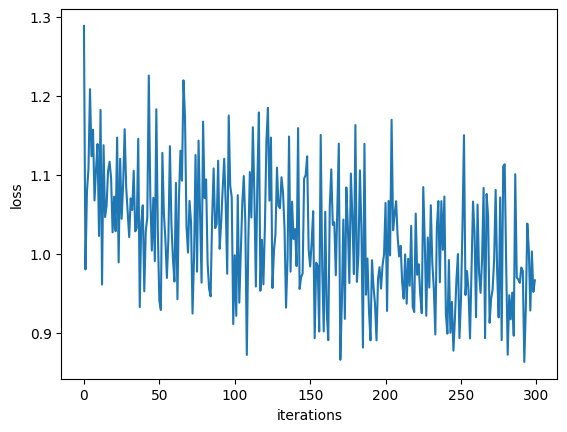

In [37]:
### TRAINING THE DATA STARTS ###
history = []
plotter = mdl.util.PeriodicPlotter(sec = 2 , xlabel='iterations', ylabel='loss')
experiment = create_experiment() 

if hasattr(tqdm , '_instances'): tqdm._instances.clear()
for iter in tqdm(range(para["num_training_iterations"])):
    x_batch , y_batch = get_batch(vectorized_songs , para['seq_length'], para['batch_size'])

    x_batch = torch.tensor(x_batch , dtype=torch.long).to(device)
    y_batch = torch.tensor(y_batch , dtype=torch.long).to(device)

    loss = train_step(x_batch , y_batch)
    experiment.log_metric("loss" , loss.item(), step = iter)

    history.append(loss.item())
    plotter.plot(history)

    if iter % 100 == 0:
        torch.save(model.state_dict(),checkpoint_prefix)

    
    torch.save(model.state_dict,checkpoint_prefix)
    experiment.flush()

In [44]:
def generate_text(model, start_string, char2idx, idx2char, device, generation_length=1000):
    model.eval()
    input_idx = [char2idx[char] for char in start_string]
    input_idx = torch.tensor([input_idx], dtype=torch.long).to(device)
    
    state = model.init_hidden(input_idx.size(0), device)
    text_generated = []
    
    for i in tqdm(range(generation_length)):
        predictions, state = model(input_idx, state, return_state=True)
        predictions = predictions.squeeze(0)
        input_idx = torch.multinomial(torch.softmax(predictions[-1], dim=-1), num_samples=1)
        text_generated.append(idx2char[input_idx.item()])
        input_idx = input_idx.unsqueeze(0)
    
    return start_string + ''.join(text_generated)

generated_text = generate_text(model, "X:", char2idx, idx2char, device)

100%|██████████| 1000/1000 [00:07<00:00, 125.91it/s]


In [45]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    experiment.log_asset(wav_file_path)

Found 1 songs in text


In [46]:
# when done, end the comet experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : native_palace_4956
COMET INFO:     url                   : https://www.comet.com/omtiwari28/genrating-music/b0adec3a1bdb4ebfafc9dbb4d75589ff
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [330] : (0.8630880117416382, 1.2884804010391235)
COMET INFO:   Parameters:
COMET INFO:     batch_size              : 8
COMET INFO:     embedding_dim           : 256
COMET INFO:     hidden_size             : 1024
COMET INFO:     learning_rate           : 0.005
COMET INFO:     num_training_iterations : 300
COMET INFO:     seq_length              : 100
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1